In [19]:
# Created on Tue Feb  7 13:59:25 2023
# Author: earyo

# In this script we fit a combination of exponential and Pareto distributions to the wealth distribution
# data in the USA from https://realtimeinequality.org/ based on Vallejos et al. (2018) and compare the
# results to the actual data. J Econ Interact Coord (2018) 13:641–656 https://doi.org/10.1007/s11403-017-0200-9

# note that vallejos have two mistakes in their eq. 8 where the p is plugged in it should be 1-p instead of p in both cases for the quantile functions. 


import os
from inequality_metrics import find_wealth_groups2
import numpy as np
from scipy.stats import expon, pareto
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Load the data


def map_percentiles_weights(percentiles_given, lower_bound, upper_bound):

    """This function create the weights for the weighted average probability distribution as a mix of 
    exponential and Pareto distributions according to eq. 9 in Vallejos et al. (2018) """

    # check percentiles_given type, if not numpy array convert to numpy array
    if type(percentiles_given) != np.ndarray:
        percentiles_given = np.array(percentiles_given)

    # create weights according to eq. 9 in Vallejos et al. (2018)
    normalization_constant = upper_bound - lower_bound
    weights = (percentiles_given - lower_bound) / normalization_constant
    # for weights smaller than lower bound of percentiles at the correct index of percentiles, set to zero
    weights[percentiles_given < lower_bound] = 0
    # for weights larger than upper bound of percentiles given, set to one
    weights[percentiles_given > upper_bound] = 1

    # make a dictionary mapping percentiles to weights
    percentiles_weights_dict = dict(zip(percentiles_given, weights))

    return percentiles_weights_dict



def weighted_avg_exp_pareto_distr(percentiles_given, lower_bound, upper_bound, alpha = 1.3, Temperature = 5, scale_factor = 1):

    """This function calculates the weighted average of the exponential and Pareto distributions as
    new wealth distribution according to Vallejos et al. (2018)"""


    #based on Vallejos et al. (2018) and compare the
    # results to the actual data. J Econ Interact Coord (2018) 13:641–656 https://doi.org/10.1007/s11403-017-0200-9

    # calculate the weights
    lower_bound = lower_bound # pass from fct. to fct. to make it more general
    upper_bound = upper_bound
    percentiles_weights_dict = map_percentiles_weights(percentiles_given, lower_bound, upper_bound)
    #print("percentiles_weights_dict", percentiles_weights_dict)
    # extract the weights as a numpy array
    weights = np.array(list(percentiles_weights_dict.values()))
    #print("weights", weights)

    # other fixed parameters
    omega = 10
    c = 1

    # wealth of percentiles given
    exponential_part = -Temperature*(1-weights)*np.log((1-percentiles_given)/c)
    #print("this is exp", exponential_part)
    pareto_part = weights * omega * (1-percentiles_given)**(-1/alpha)
    #print("this is pareto", pareto_part)
    wealth_of_percentiles = exponential_part + pareto_part

    return wealth_of_percentiles * scale_factor


def optimize_weighted_distr_fit(lower_bound_range, upper_bound_range, alpha_range, Temperature_range, empirical_distr):
    
    """This function optimizes the weighted average of the exponential and Pareto distributions dependent on the 
    distribution parameters and with respect to the Wealth distribution data in the USA"""
    
    # define the empirical distribution
    q = empirical_distr
    
    # create a list to store results
    results = []

    percentiles_given = np.linspace(0, 1, 1100)

    # remove the first and last percentiles
    percentiles_given = percentiles_given[1:-1]

    for i in tqdm(range(len(alpha_range))):
        for j in range(len(lower_bound_range)):
            for k in range(len(upper_bound_range)):
                for l in range(len(Temperature_range)):
                    
                    try:
                        r = weighted_avg_exp_pareto_distr(percentiles_given, lower_bound_range[j], upper_bound_range[k], alpha_range[i], Temperature_range[l])
                        w = find_wealth_groups2(r, sum(r))[1]
                        if len(w) != len(q):
                            # sum the w for the last two w groups
                            w[-2] = w[-2] + w[-1]
                            # remove the last w group
                            w = w[:-1]
                            # check that now the length of w is the same as q
                            assert len(w) == len(q)
                        z = [x*100 for x in w]
                        minimization_fct = sum([abs(z[x] - q[x]) for x in range(len(q))])
                        results.append([lower_bound_range[j], upper_bound_range[k], alpha_range[i], Temperature_range[l], minimization_fct])

                    except Exception as e:
                        print(f"Error at indices ({i}, {j}, {k}, {l}): {e}")

    # convert results to a DataFrame
    df_results = pd.DataFrame(results, columns=['lower_bound', 'upper_bound', 'alpha', 'temperature', 'minimization_fct'])
    return df_results

### Display distribution example 


mean 230747.6824912517
std 956003.1145381241


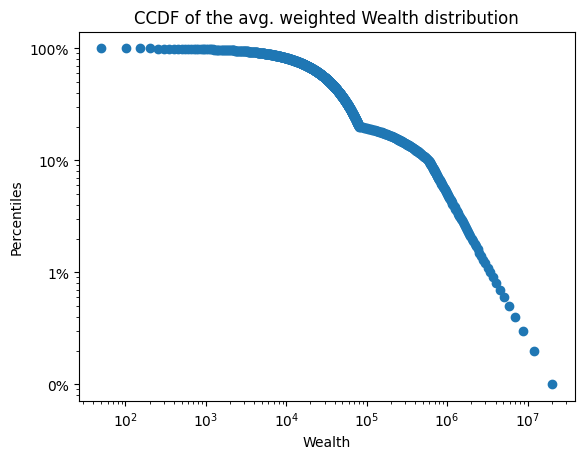

In [20]:
# test the above function with some example data and bounds say percentiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] and lower_bound = 0.1 and upper_bound = 0.9
percentiles_given = np.linspace(0, 1, 1000)
# do  not include first and last percentiles values where it equals 0 and 1
percentiles_given = percentiles_given[1:-1]
lower_bound = 0.8
upper_bound = 0.9
wealth_of_percentiles = weighted_avg_exp_pareto_distr(percentiles_given, lower_bound, upper_bound, scale_factor=10000)
#compute mean and std of the wealth distribution
mean = np.mean(wealth_of_percentiles)
std = np.std(wealth_of_percentiles)
print("mean", mean)
print("std", std)
#print(wealth_of_percentiles)
# run map_percentiles_weights function
percentiles_weights_dict = map_percentiles_weights(percentiles_given, lower_bound, upper_bound)
weights = np.array(list(percentiles_weights_dict.values()))

plt.scatter(wealth_of_percentiles, 1-percentiles_given) # 1- percentiles to get the CCDF instead of the CDF
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Wealth")
plt.ylabel("Percentiles")
plt.title("CCDF of the avg. weighted Wealth distribution")
# display y axis as percentage points
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.show()

### TEST calibration on three wealth groups only

wealth_group_list [30.95568846 77.14440197 22.85559803]


[Text(0.175, 0, 'Top 1%'),
 Text(1.175, 0, 'Top 10%'),
 Text(2.175, 0, 'Bottom 90%')]

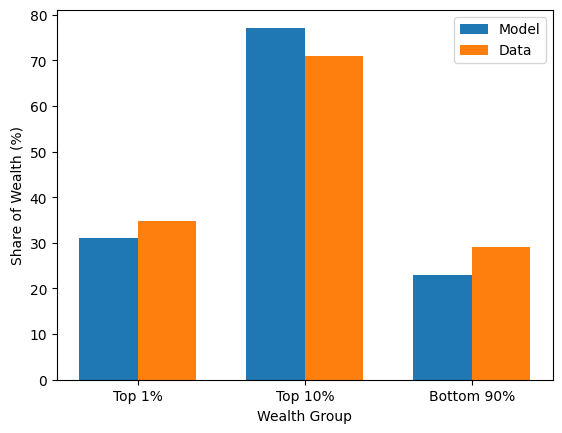

In [21]:
# compute share of wealth for the aggregate top 1% and aggregate top 10% and the aggregate bottom 90% of the population 
# using the wealth_of_percentiles and percentiles_given
# top 1% is the sum of the wealth of the top 1% of the population
# sum the wealth of the top 1% of the population and as percent of total wealth
top_1_percent_share = np.sum(wealth_of_percentiles[percentiles_given > 0.99])/np.sum(wealth_of_percentiles)
# top 10% is the sum of the wealth of the top 10% of the population
top_10_percent_share = np.sum(wealth_of_percentiles[percentiles_given > 0.9])/np.sum(wealth_of_percentiles)
# bottom 90% is the sum of the wealth of the bottom 90% of the population
bottom_90_percent_share = np.sum(wealth_of_percentiles[percentiles_given < 0.9])/np.sum(wealth_of_percentiles)

# store as list for later use
wealth_group_list = [top_1_percent_share, top_10_percent_share, bottom_90_percent_share]
# as percentage points
wealth_group_list = np.array(wealth_group_list)*100
print("wealth_group_list", wealth_group_list)

# compare against the actual data
### empirical wealth shares top 1%, top10%, bottom 90% of wealth owners in 2019 in the USA
empirical_wealth_shares_three_groups = [34.8, 70.9, 29]

#plot against actual data as bar charts
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(3)
bar1 = ax.bar(index, wealth_group_list, bar_width, label='Model')
bar2 = ax.bar(index + bar_width, empirical_wealth_shares_three_groups, bar_width, label='Data')
ax.set_xlabel('Wealth Group')
ax.set_ylabel('Share of Wealth (%)')
ax.legend()
# label the x axis with the wealth groups top1% top10% and bottom 90%
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Top 1%', 'Top 10%', 'Bottom 90%'])


### Run optimization on three wealth groups

In [22]:
alpha_data  = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
lower_bound_data = [0.4, 0.5, 0.6, 0.7, 0.8]
upper_bound_data = [0.9]
Temperature_data = [0.1, 0.5, 5]
empirical_wealth_shares_three_groups = [34.8, 70.9, 29]

opti_output = optimize_weighted_distr_fit(lower_bound_range= lower_bound_data,
                                          upper_bound_range= upper_bound_data,
                                          alpha_range = alpha_data,
                                          Temperature_range=Temperature_data,
                                          empirical_distr=empirical_wealth_shares_three_groups)

# find the minimum value of the minimization function and the corresponding parameters
min_value = opti_output.minimization_fct.min()
min_index = opti_output.minimization_fct.idxmin()
min_parameters = opti_output.iloc[min_index, :]
print("min_value", min_value, "min_index", min_index, "min_parameters", min_parameters)



100%|██████████| 10/10 [00:00<00:00, 99.69it/s]

min_value 33.36641756327002 min_index 44 min_parameters lower_bound          0.800000
upper_bound          0.900000
alpha                1.300000
temperature          5.000000
minimization_fct    33.366418
Name: 44, dtype: float64


### Calibrate on four wealth groups 


In [23]:
alpha_data  = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
lower_bound_data = [0.4, 0.5, 0.6, 0.7, 0.8]
upper_bound_data = [0.9]
Temperature_data = [0.1, 0.5, 5]
#data for 1990 top 1%, top 10%, next 40%, and bottom 50%.
empirical_wealth_shares_four_groups = [28.6, 64.7, 33.4, 1.8]

opti_output2 = optimize_weighted_distr_fit(lower_bound_range= lower_bound_data,
                                          upper_bound_range= upper_bound_data,
                                          alpha_range = alpha_data,
                                          Temperature_range=Temperature_data,
                                          empirical_distr=empirical_wealth_shares_four_groups)



# find the minimum value of the minimization function and the corresponding parameters
min_value = opti_output2.minimization_fct.min()
min_index = opti_output2.minimization_fct.idxmin()
min_parameters = opti_output2.iloc[min_index, :]
print("min_value", min_value, "min_index", min_index, "min_parameters", min_parameters)

100%|██████████| 10/10 [00:00<00:00, 108.51it/s]

min_value 27.225538997808368 min_index 31 min_parameters lower_bound          0.400000
upper_bound          0.900000
alpha                1.300000
temperature          0.500000
minimization_fct    27.225539
Name: 31, dtype: float64


### Display optimal calibration four groups

wealth_group_list [27.5460487  68.64726839 30.4418745   0.91085711]


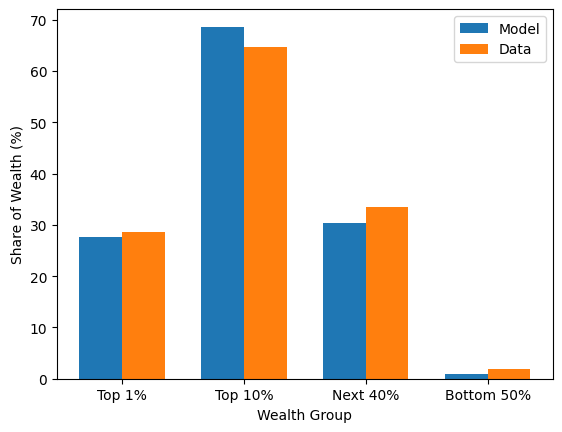

In [24]:
# calculate new wealth distribution with the optimized parameters
lower_bound = 0.4
upper_bound = 0.9
Temperature = 0.5
alpha = 1.3
wealth_of_percentiles2 = weighted_avg_exp_pareto_distr(percentiles_given, lower_bound, upper_bound, alpha, Temperature)

# build four wealth groups from wealth_percentiles
# top 1% is the sum of the wealth of the top 1% of the population
# sum the wealth of the top 1% of the population and as percent of total wealth
top_1_percent_share2 = np.sum(wealth_of_percentiles2[percentiles_given > 0.99])/np.sum(wealth_of_percentiles2)
# top 10% is the sum of the wealth of the top 10% of the population
top_10_percent_share2 = np.sum(wealth_of_percentiles2[percentiles_given > 0.9])/np.sum(wealth_of_percentiles2)
# next 40% is the sum of the wealth of the next 40% of the population
next_40_percent_share2 = np.sum(wealth_of_percentiles2[(percentiles_given > 0.5) & (percentiles_given < 0.9)])/np.sum(wealth_of_percentiles2)
# bottom 50% is the sum of the wealth of the bottom 50% of the population
bottom_50_percent_share2 = np.sum(wealth_of_percentiles2[percentiles_given < 0.5])/np.sum(wealth_of_percentiles2)

#data for 1990 top 1%, top 10%, next 40%, and bottom 50%.
empirical_wealth_shares_four_groups = [28.6, 64.7, 33.4, 1.8]

# store as list for later use
wealth_group_list2 = [top_1_percent_share2, top_10_percent_share2, next_40_percent_share2, bottom_50_percent_share2]

# as percentage points
wealth_group_list2 = np.array(wealth_group_list2)*100 # convert to percentage points
print("wealth_group_list", wealth_group_list2)

# compare against the actual data
### empirical wealth shares top 1%, top10%, bottom 90% of wealth owners in 2019 in the USA  
empirical_wealth_shares_four_groups = [28.6, 64.7, 33.4, 1.8]

#plot against actual data as bar charts
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(4)
bar1 = ax.bar(index, wealth_group_list2, bar_width, label='Model')
bar2 = ax.bar(index + bar_width, empirical_wealth_shares_four_groups, bar_width, label='Data')
ax.set_xlabel('Wealth Group')
ax.set_ylabel('Share of Wealth (%)')
ax.legend()
# label the x axis with the wealth groups top1% top10% next 40% and bottom 50%
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Top 1%', 'Top 10%', 'Next 40%', 'Bottom 50%'])

# save figure 300 dpi as supplementary figure 1

plt.savefig('suppfig1.png', dpi=300)



## NOW set up Inverse transform sampling and test whether you achieve the same accuracy as above 

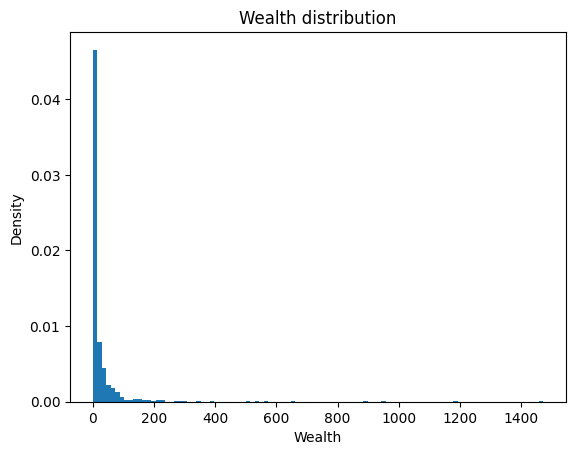

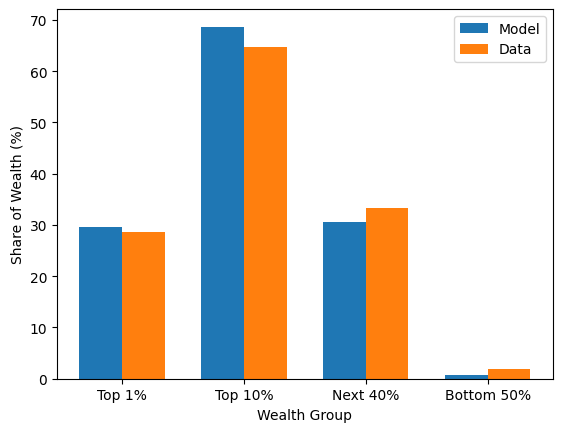

In [25]:
# use inverse transform sampling with uniform random numbers to generate a sample from the weighted average wealth distribution
# generate uniform random numbers
n = 1000
u = np.random.uniform(0, 1, n)
# sort u in ascending order
u = np.sort(u)
# use above defined weighted_avg_exp_pareto_distr function to generate the wealth distribution where percentiles given is the uniform random numbers
# calculate new wealth distribution with the optimized parameters
lower_bound = 0.4
upper_bound = 0.9
Temperature = 0.5
alpha = 1.3
wealth_of_percentiles_inverse_sampling = weighted_avg_exp_pareto_distr(u, lower_bound, upper_bound, alpha, Temperature)


# plot the generated wealth distribution
plt.hist(wealth_of_percentiles_inverse_sampling, bins=100, density=True)
plt.xlabel("Wealth")
plt.ylabel("Density")
plt.title("Wealth distribution")
plt.show()

# plot against the actual data of the four wealth groups in 1990
#data for 1990 top 1%, top 10%, next 40%, and bottom 50%.

# build four wealth groups from wealth_percentiles
# top 1% is the sum of the wealth of the top 1% of the population
# sum the wealth of the top 1% of the population and as percent of total wealth
top_1_percent_share = np.sum(wealth_of_percentiles_inverse_sampling[u > 0.99])/np.sum(wealth_of_percentiles_inverse_sampling)
# top 10% is the sum of the wealth of the top 10% of the population
top_10_percent_share = np.sum(wealth_of_percentiles_inverse_sampling[u > 0.9])/np.sum(wealth_of_percentiles_inverse_sampling)
# next 40% is the sum of the wealth of the next 40% of the population
next_40_percent_share = np.sum(wealth_of_percentiles_inverse_sampling[(u > 0.5) & (u < 0.9)])/np.sum(wealth_of_percentiles_inverse_sampling)
# bottom 50% is the sum of the wealth of the bottom 50% of the population
bottom_50_percent_share = np.sum(wealth_of_percentiles_inverse_sampling[u < 0.5])/np.sum(wealth_of_percentiles_inverse_sampling)

# store as list for later use
wealth_group_list = [top_1_percent_share, top_10_percent_share, next_40_percent_share, bottom_50_percent_share]
# as percentage points
wealth_group_list = np.array(wealth_group_list)*100 # convert to percentage points

### empirical wealth shares top 1%, top10%, bottom 90% of wealth owners in 2019 in the USA  
empirical_wealth_shares_four_groups = [28.6, 64.7, 33.4, 1.8]


#plot against actual data as bar charts
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(4)
bar1 = ax.bar(index, wealth_group_list, bar_width, label='Model')
bar2 = ax.bar(index + bar_width, empirical_wealth_shares_four_groups, bar_width, label='Data')
ax.set_xlabel('Wealth Group')
ax.set_ylabel('Share of Wealth (%)')
ax.legend()
# label the x axis with the wealth groups top1% top10% next 40% and bottom 50%
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Top 1%', 'Top 10%', 'Next 40%', 'Bottom 50%'])
plt.show()

### MAP SCALE FACTOR to average wealth over time
#### this section is about finding the scale factor for the exponential pareto distribution that needs to be taken for each year


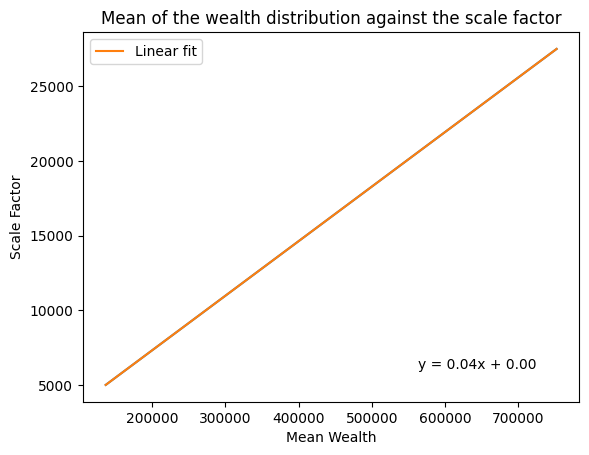

In [26]:

# load csv average_wealth_for_every_year
df_average_wealth = pd.read_csv("../data/average_wealth_for_every_year.csv", sep=",")
percentiles_given = np.linspace(0, 1, 1000)
# do  not include first and last percentiles values where it equals 0 and 1
percentiles_given = percentiles_given[1:-1]
lower_bound = 0.4
upper_bound = 0.9

# make list of scale factors 5000 to 30000 in steps of 2500 
list_of_scale_factors = list(np.arange(5000, 30000, 2500))
# make list of means that need to be captured for each scale factor
list_of_means = []

for scale_factor in list_of_scale_factors:
    wealth_of_percentiles = weighted_avg_exp_pareto_distr(percentiles_given, lower_bound, upper_bound, scale_factor=scale_factor)
    mean = np.mean(wealth_of_percentiles)
    list_of_means.append(mean)

# plot the means against the scale factors
plt.plot(list_of_means, list_of_scale_factors)
plt.xlabel("Mean Wealth")
plt.ylabel("Scale Factor")
plt.title("Mean of the wealth distribution against the scale factor")
# model the data with a linear fit
m, b = np.polyfit(list_of_means, list_of_scale_factors, 1)
plt.plot(list_of_means, m*np.array(list_of_means) + b, label="Linear fit")
plt.legend()
# also plot the equation in lower right of plot 
plt.text(0.8, 0.1, f"y = {m:.2f}x + {b:.2f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()

## Map scale factors to years

In [27]:

# remove all rows with years > 2022
df_average_wealth = df_average_wealth[df_average_wealth['Year'] <= 2022]
# Create an array with numbers 1 to 12
cycle = np.arange(1, 13)

# Repeat the cycle enough times to get at least 564 elements
repeated_array = np.tile(cycle, (564 // len(cycle) + 1))

# Trim the array to exactly 564 elements
final_array = repeated_array[:564]

# rename column Quarter to months
df_average_wealth = df_average_wealth.rename(columns={'Quarter': 'Months'})


# Create a DataFrame and insert the array into column 'X'
df_average_wealth['Months'] = final_array

# add a column that gives the right scale factor for each starting point 
df_average_wealth['scale_factor'] = 0.04 * df_average_wealth['Months']